In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import re
import matplotlib.ticker as ticker
import seaborn

In [7]:
best_params = {'-lsq:size': 4,
 '-ruu:size': 8,
 '-cache:dl1': 'dl1:8:32:4:l',
 '-res:ialu': 2,
 '-issue:width': 2,
 '-bpred': 'comb',
 '-bpred:btb': '1 8',
 '-cache:il1': 'il1:16:64:4:l',
 '-bpred:comb': 8}

# Takes a list of parameter strings and runs the simulator with each of them
# E.g. run_command(['-ruu:size 2', '-ruu:size 4']) == [
#   {'total_power_cycle_cc1': 1031971444.5013, ... }
#   {'total_power_cycle_cc1': 768561902.5089, ... }
# ]
def run_wattch(paramss, ignore_best=False):
    global best_params

    # Helper function
    def try_numeral(n):
      try:
        return int(n)
      except ValueError:
        try:
          return float(n)
        except ValueError:
          return n

    # Start all the processes
    procs = [
        subprocess.Popen(
            ['./run-wattch'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True,
            env={
               **os.environ.copy(),
               'SSFLAGS': ' '.join(
                  f'{key} {val}'
                  for key, val in {**({} if ignore_best else best_params), **params}.items()
                ) 
            }
        )
        for params in paramss
    ]

    # Wait for them all to finish and parse output
    return pd.DataFrame(
        {
            match.group(1): try_numeral(match.group(2))
            for match in re.finditer(r'\n([^ ]+)[ ]+([^\#]+)\# ', '\n'.join(proc.communicate()))
        }
        for proc in procs
    )

def plot_2d(df, x_var, y_var='total_power_cycle_cc1', title=None, file_name=None):
    plot = seaborn.pointplot(df, x=x_var, y=y_var)
        
    if title:
        plot.set_title(title)

    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')

def run_and_plot(x_var, x_var_vals, y_var='total_power_cycle_cc1'):
    df = run_wattch([{x_var: x_var_val} for x_var_val in x_var_vals])
    plot_2d(df, x_var, y_var)

def plot_3d(data, x, y, z='total_power_cycle_cc1', title=None, file_name=None):
    qualitative_colors = seaborn.color_palette("husl", 9)[:len(data[z].unique())]
    
    plot = seaborn.pointplot(data=data, x=x, y=y, hue=z, palette=qualitative_colors)
    
    if title:
        plot.set_title(title)
    
    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')


# Mandatory Questions

In [7]:
# 1. Vary RUU size
results = run_wattch([
  {'-ruu:size': 2 ** i}
  for i in range(0, 9)
])

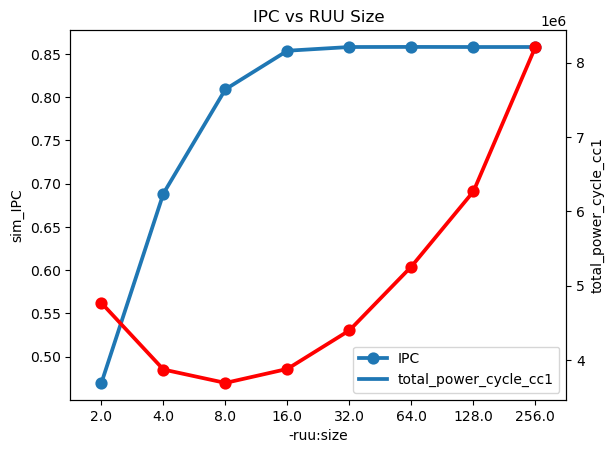

In [8]:

ipc_plot = seaborn.pointplot(results, x='-ruu:size', y='sim_IPC')
ipc_plot.set_title('IPC vs RUU Size')

# Using twinx, we add a second y-axis on the right-hand side which contains total_power_cycle_cc1
ax2 = ipc_plot.twinx()
ax2.set_ylabel('total_power_cycle_cc1')
seaborn.pointplot(results, x='-ruu:size', y='total_power_cycle_cc1', ax=ax2, color='r')

# Show the ledgend so you can tell the two lines apart
ipc_plot.legend(['IPC', 'total_power_cycle_cc1'])

plt.savefig('./report/assets/ipc_vs_ruu_size.png')

In [9]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  {'-ruu:size': 2 ** i, '-lsq:size': 2 ** j}
  # for i in range(2, 8)
  # for j in range(1, 7)
  for i in range(2, 7)
  for j in range(1, 6)
])

/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit con

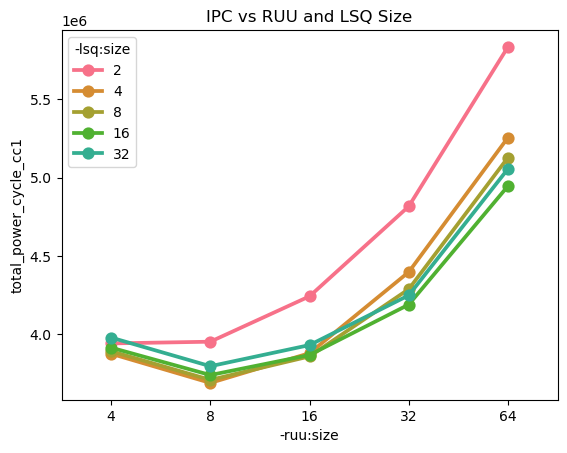

In [10]:
plot_3d(
  results,
  '-ruu:size',
  'total_power_cycle_cc1',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'energy_vs_ruu_and_lsq_size'
)

In [11]:
# Update best params
best_params = {**best_params, '-lsq:size': 4, '-ruu:size': 8}

In [12]:
# 3. Is RUU or LSQ the bottleneck?
increasing_ruu = run_wattch([
  {'-ruu:size': 2 ** i}
  for i in range(4, 9)
])
increasing_lsq = run_wattch([
  {'-lsq:size': 2 ** i}
  for i in range(3, 8)
])

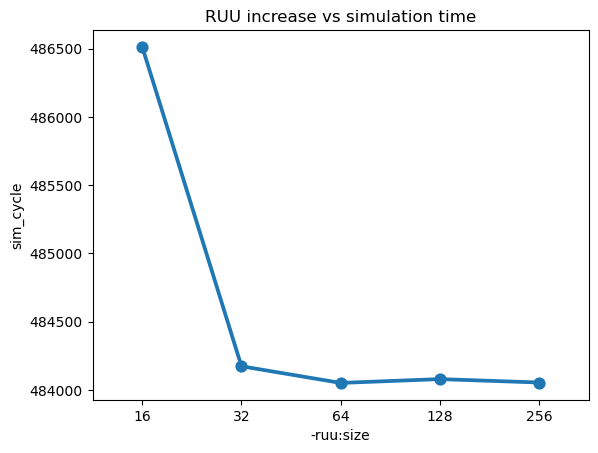

In [13]:

time_plot = seaborn.pointplot(increasing_ruu, x='-ruu:size', y='sim_cycle')
time_plot.set_title('RUU increase vs simulation time')

plt.savefig('./report/assets/ruu_bottleneck.png')

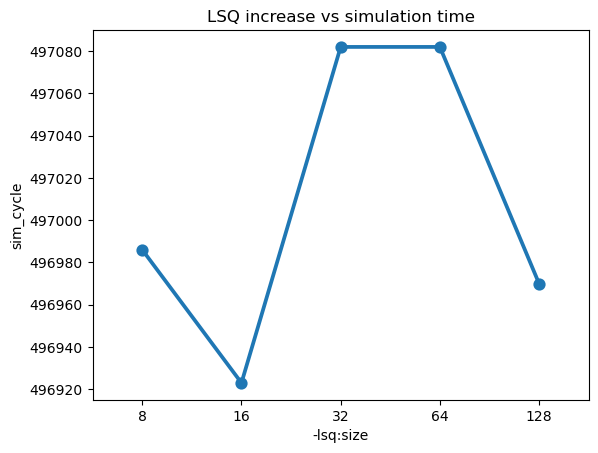

In [14]:
time_plot = seaborn.pointplot(increasing_lsq, x='-lsq:size', y='sim_cycle')
time_plot.set_title('LSQ increase vs simulation time')

plt.savefig('./report/assets/lsq_bottleneck.png')

In [15]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  {'-ruu:size': 2 ** i, '-lsq:size': 2 ** j}
  for i in range(2, 8)
  for j in range(1, 7)
])

/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2673050/1110253830.py:79: MatplotlibDeprecationWarning: Support for passing numbers through unit con

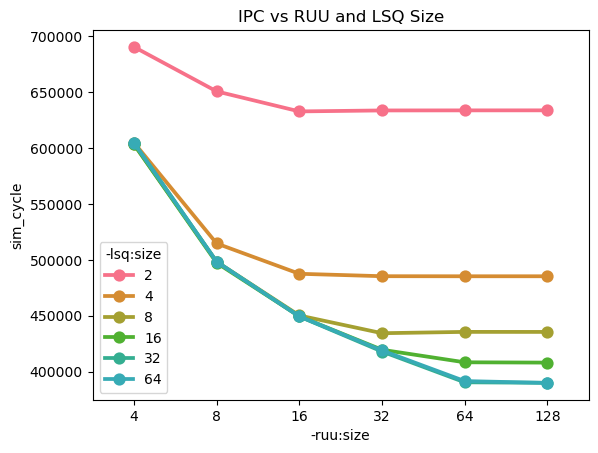

In [16]:
plot_3d(
  results,
  '-ruu:size',
  'sim_cycle',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'ruu_and_lsq_vs_sim_time'
)

# Caches

## L1 Block Size

In [17]:
bsizes = [8, 16, 32, 64, 128, 256, 512, 1024]
# L1 data cache experiments
l1bsize_cache_results = run_wattch([
  {'-cache:dl1': f'dl1:{128 * 32//bsize}:{bsize}:4:l'}
  for bsize in bsizes
])
l1bsize_cache_results['bsize'] = bsizes

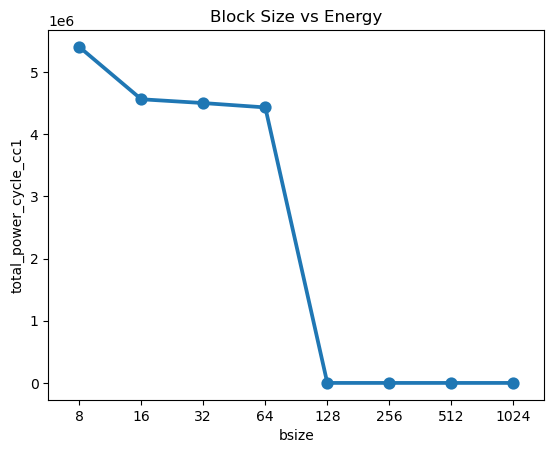

In [18]:
bsize_vs_energy = seaborn.pointplot(l1bsize_cache_results, x='bsize', y='total_power_cycle_cc1')
bsize_vs_energy.set_title('Block Size vs Energy')
plt.savefig('report/assets/l1bsize_vs_energy.png')

## L1 Cache Size

In [19]:
csizes = [2 ** i for i in range(8, 16)]
# L1 data cache experiments
l1csize_cache_results = run_wattch([
  {'-cache:dl1': f'dl1:{csize // 128}:32:4:l'}
  for csize in csizes
])
l1csize_cache_results['csize'] = csizes

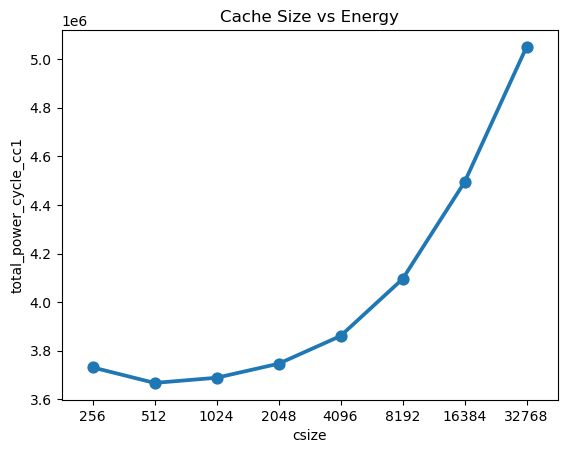

In [20]:
csize_vs_energy = seaborn.pointplot(l1csize_cache_results, x='csize', y='total_power_cycle_cc1')
csize_vs_energy.set_title('Cache Size vs Energy')
plt.savefig('report/assets/l1csize_vs_energy.png')

In [21]:
# Update best params
best_params = {**best_params, '-cache:dl1': 'dl1:4:32:4:l'}

In [22]:
bsizes = [8, 16, 32, 64, 128, 256, 512, 1024]
# L1 data cache experiments
l1bsize_cache_results2 = run_wattch([
  {'-cache:dl1': f'dl1:{4 * 32//bsize}:{bsize}:4:l'}
  for bsize in bsizes
])
l1bsize_cache_results2['bsize'] = bsizes

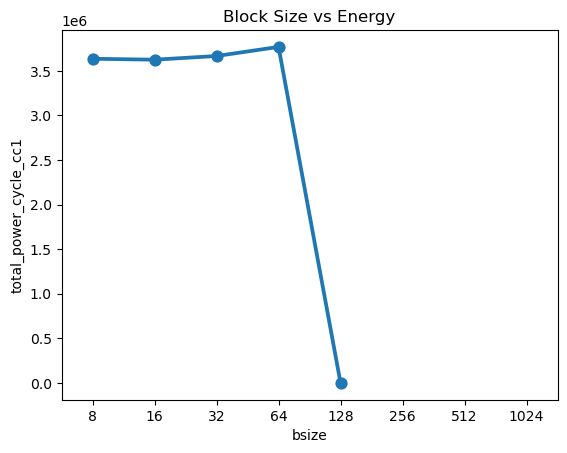

In [23]:
bsize_vs_energy2 = seaborn.pointplot(l1bsize_cache_results2, x='bsize', y='total_power_cycle_cc1')
bsize_vs_energy2.set_title('Block Size vs Energy')
plt.savefig('report/assets/l1bsize_vs_energy2.png')

## L2 Cache Size

In [24]:
nsetss = [2 ** i for i in range(2, 13)]
l2_cache_size_results = run_wattch([
  {'-cache:dl2': f'dl2:{i}:64:4:l'}
  for i in nsetss
])
l2_cache_size_results['nsets'] = nsetss

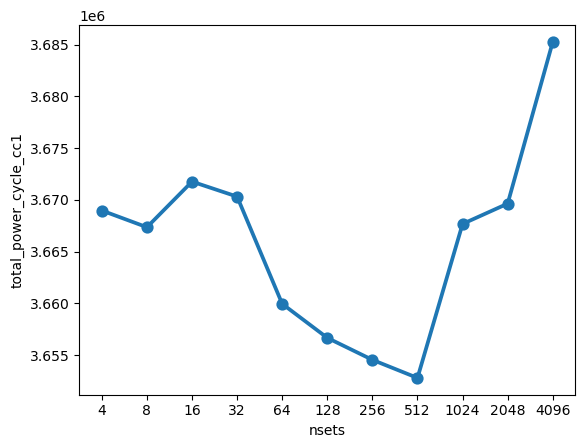

In [25]:
plot_2d(l2_cache_size_results, 'nsets', 'total_power_cycle_cc1')

# Functional Units

In [26]:
units_results = []

for ifp in ['i', 'fp']:
  for alumult in ['alu', 'mult']:
    results = run_wattch([
      {f'-res:{ifp}{alumult}': f'{i}'}
      for i in [1, 2, 3, 4, 8]
    ])
    results['varied_unit'] = f'{ifp}{alumult}' # f"{'int' if ifp == 'i' else 'float'}{'alu' if alumult == 'alu' else 'mult'}"
    results['varied_unit_n'] = [1, 2, 3, 4, 8]
    units_results.append(results)

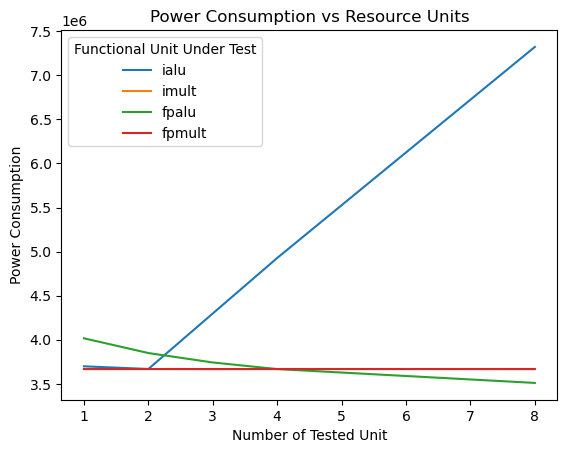

In [27]:
# Concatenate all the results into a single dataframe
results_df = pd.concat(units_results)

# Plot the results
seaborn.lineplot(
  data=results_df,
  x='varied_unit_n',
  y='total_power_cycle_cc1',
  hue='varied_unit'
)

# Set the title and axis labels
plt.title('Power Consumption vs Resource Units')
plt.xlabel('Number of Tested Unit')
plt.ylabel('Power Consumption')

# Show the legend
plt.legend(title='Functional Unit Under Test')

plt.savefig('report/assets/units_vs_energy.png')


In [28]:
best_params = {**best_params, '-res:ialu': 2}

# Width of Issue/Decode/Commit Stages

In [10]:
stage_width_results = []
for stage in ['decode', 'issue', 'commit']:
  for width in [1, 2, 4, 8]:
    results = run_wattch([
      {f'-{stage}:width': f'{width}'}
    ], ignore_best=False)
    results['varied_stage'] = stage
    results['varied_stage_width'] = width
    stage_width_results.append(results)

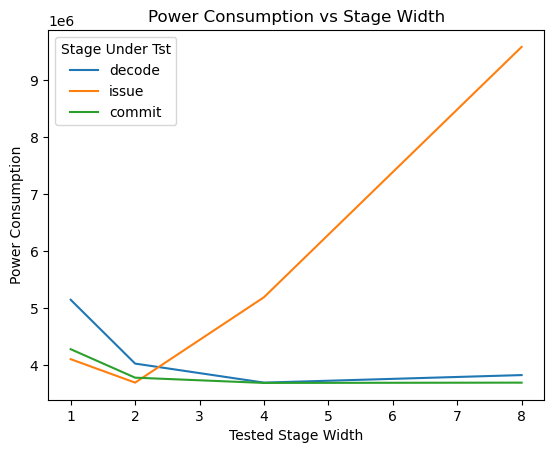

In [11]:
# Concatenate all the results into a single dataframe
results_df = pd.concat(stage_width_results)

# Plot the results
seaborn.lineplot(
  data=results_df,
  x='varied_stage_width',
  y='total_power_cycle_cc1',
  hue='varied_stage'
)

# Set the title and axis labels
plt.title('Power Consumption vs Stage Width')
plt.xlabel('Tested Stage Width')
plt.ylabel('Power Consumption')

# Show the legend
plt.legend(title='Stage Under Tst')

plt.savefig('report/assets/stage_width_vs_energy.png')


In [31]:
best_params = {**best_params, '-issue:width': 2}

# Branch Predictor

In [32]:
bpred_results = run_wattch([
  {'-bpred': bpred}
  for bpred in ['nottaken', 'taken', 'perfect', 'bimod', '2lev', 'comb']
])

<AxesSubplot:xlabel='-bpred'>

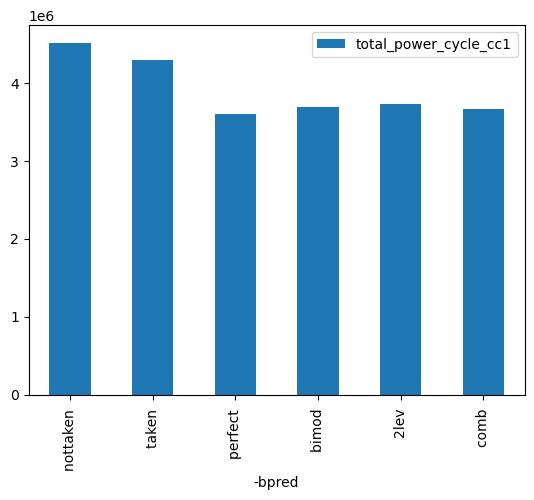

In [33]:
bpred_results.plot(x='-bpred', y='total_power_cycle_cc1', kind='bar')

In [34]:
best_params = {**best_params, '-bpred': 'comb'}

In [35]:
meta_table_results = run_wattch([
  {'-bpred:comb': f'{2 ** i}'}
  for i in range(2, 13)
])

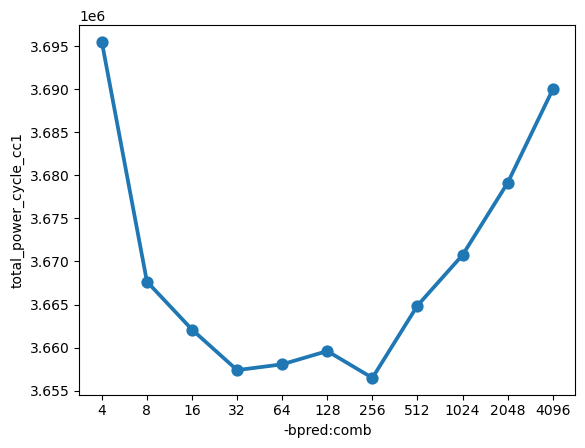

In [36]:
plot_2d(meta_table_results, '-bpred:comb', 'total_power_cycle_cc1')

In [37]:
best_params = {**best_params, '-bpred:comb': 8}

In [38]:
btb_sizes = [2 ** i for i in range(0, 13)]
btb_size_results = run_wattch([
  {'-bpred:btb': f'{i} 8'}
  for i in btb_sizes
])
btb_size_results['btb_size'] = btb_sizes

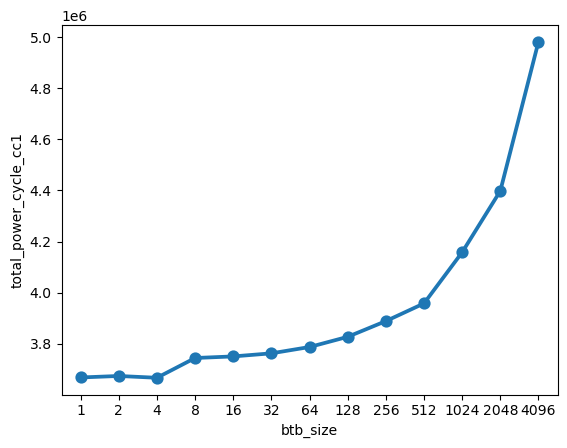

In [39]:
plot_2d(btb_size_results, 'btb_size', 'total_power_cycle_cc1')

In [40]:
best_params = {**best_params, '-bpred:btb': '1 8'}

# Instruction Caches

In [41]:
nsetss = [2 ** i for i in range(2, 12)]
l2_icache_size_results = run_wattch([
  {'-cache:il1': f'dl2:{i}:64:4:l'}
  for i in nsetss
])
l2_icache_size_results['nsets'] = nsetss

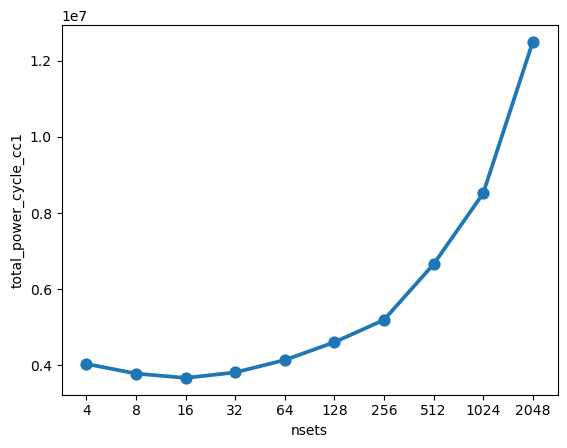

In [42]:
# 16
plot_2d(l2_icache_size_results, 'nsets', 'total_power_cycle_cc1')

In [43]:
best_params = {**best_params, '-cache:il1': 'il1:16:64:4:l'}

## L1 and L2 Data Cache Associativity

In [44]:
assocs = [2 ** i for i in range(0, 3)]
l2_cache_assoc_results = run_wattch([
  {'-cache:dl1': f'dl1:8:32:{i}:l', '-cache:dl2': f'dl2:256:64:{i}:l'}
  for i in assocs
])
l2_cache_assoc_results['assoc'] = assocs

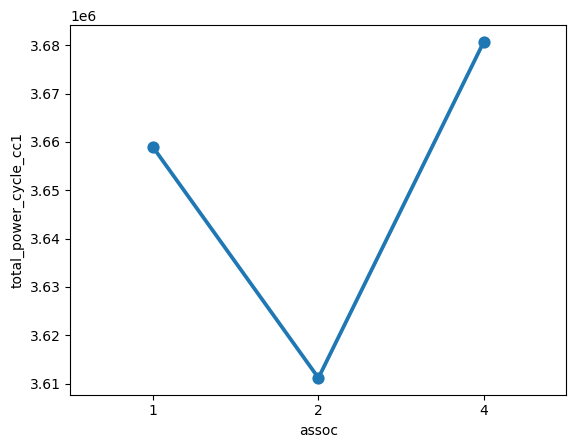

In [45]:
plot_2d(l2_cache_assoc_results, 'assoc', 'total_power_cycle_cc1')

# IFQ

In [46]:
ifq_results = run_wattch([
  {'-fetch:ifqsize': f'{2 ** i}'}
  for i in range(0, 5)
])

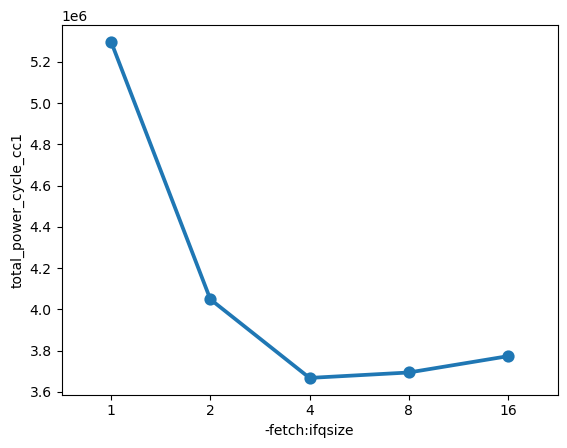

In [47]:
plot_2d(ifq_results, '-fetch:ifqsize', 'total_power_cycle_cc1')

# Summary

In [48]:
best_params

{'-lsq:size': 4,
 '-ruu:size': 8,
 '-cache:dl1': 'dl1:4:32:4:l',
 '-res:ialu': 2,
 '-issue:width': 2,
 '-bpred': 'comb',
 '-bpred:btb': '1 8',
 '-cache:il1': 'il1:16:64:4:l',
 '-bpred:comb': 8}

In [49]:
baseline_energy = run_wattch([{}])['total_power_cycle_cc1'][0]

removed = list(best_params.keys())
removed_results = run_wattch([
  {i: best_params[i] for i in best_params if i != key}
  for key in removed
], ignore_best=True)
removed_results['removed'] = removed
removed_results['parameter_effectiveness'] = removed_results['total_power_cycle_cc1'] - baseline_energy

<AxesSubplot:xlabel='removed'>

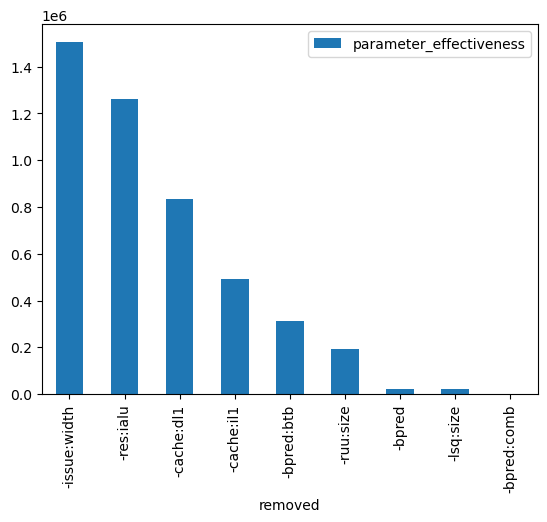

In [50]:
removed_results.sort_values('parameter_effectiveness', ascending=False).plot(x='removed', y='parameter_effectiveness', kind='bar')

In [51]:
best_params

{'-lsq:size': 4,
 '-ruu:size': 8,
 '-cache:dl1': 'dl1:4:32:4:l',
 '-res:ialu': 2,
 '-issue:width': 2,
 '-bpred': 'comb',
 '-bpred:btb': '1 8',
 '-cache:il1': 'il1:16:64:4:l',
 '-bpred:comb': 8}